This notebook contains the results for the complete dataset from Austin for the year 2014.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import sys

In [3]:
from common import compute_rmse_fraction

In [4]:
thresholds = {'fridge':10,'hvac':100,'dw':0.5,'mw':0.5,'oven':0.5,'wm':0.5}

In [5]:
from create_matrix import *
from sklearn.metrics import mean_squared_error
def compute_rmse_fraction(appliance, pred_df, region='Austin',year=2014):
    appliance_df = create_matrix_region_appliance_year(region, year, appliance)

    if appliance == "hvac":
        start, stop = 5, 11
    else:
        start, stop = 1, 13
    pred_df = pred_df.copy()
    pred_df.columns = [['%s_%d' % (appliance, month) for month in range(start, stop)]]
    gt_df = appliance_df[pred_df.columns].ix[pred_df.index]
    
    if appliance in thresholds:
        a = gt_df[gt_df<thresholds[appliance]].sum(axis=1)
        homes_ignore = a[a>0].index
        gt_df_index = [x for x in gt_df.index if x not in homes_ignore]
        gt_df = gt_df.ix[gt_df_index]
    

    aggregate_df = appliance_df.ix[pred_df.index][['aggregate_%d' % month for month in range(start, stop)]]

    aggregate_df.columns = gt_df.columns
    rows, cols = np.where((aggregate_df < 300))
    for r, c in zip(rows, cols):
        r_i, c_i = aggregate_df.index[r], aggregate_df.columns[c]
        aggregate_df.loc[r_i, c_i] = np.NaN

    gt_fraction = gt_df.div(aggregate_df) * 100
    pred_fraction = pred_df.div(aggregate_df) * 100

    gt_fraction_dropna = gt_fraction.unstack().dropna()
    pred_fraction_dropna = pred_fraction.unstack().dropna()
    index_intersection = gt_fraction_dropna.index.intersection(pred_fraction_dropna.index)
    gt_fraction_dropna = gt_fraction_dropna.ix[index_intersection]
    pred_fraction_dropna = pred_fraction_dropna.ix[index_intersection]
    difference_error = (gt_fraction_dropna-pred_fraction_dropna).abs()

    rms = np.sqrt(mean_squared_error(gt_fraction_dropna, pred_fraction_dropna))
    return gt_fraction_dropna, pred_fraction_dropna, rms, difference_error

In [6]:
from plot_functions import *

In [7]:
import pickle

### Loading all the prediction files

In [8]:
knn_p= pickle.load(open("predictions/knn_all_homes.pkl","r"))
tensor_custom_p = pickle.load(open("predictions/o_tf.pkl",'r'))['tf']
tensor_custom_static_weather_p = pickle.load(open("predictions/o_tf_energy_static.pkl",'r'))['tf_energy_static']
mf_p = pickle.load(open("predictions/o_mf.pkl",'r'))['mf']
tensor_all_p = pickle.load(open("predictions/o_tf_all_appliances.pkl",'r'))['tf_all_appliances']
tensor_all_static_p = pickle.load(open("predictions/o_tf_all_appliances_static_weather.pkl",'r'))['tf_all_appliances_static_weather']
mf_all_p = pickle.load(open("predictions/o_mf_all_appliances.pkl",'r'))['mf_all_appliances']


### KNN prediction and Sensitivity analysis

In [9]:
sanity_num_points = {}

In [10]:
knn= {}
sensitivity_knn={}
sanity_num_points = {}
for appliance in knn_p.keys()[:]:
    print(appliance)
    knn[appliance] = {}
    sensitivity_knn[appliance]={}
    sanity_num_points[appliance]={}
    for feature in ['energy', 'energy_static']:
        sanity_num_points[appliance][feature]={}
        sensitivity_knn[appliance][feature]={}
        best_error = 1e6
        for n in range(1, 10):
            pred = pd.DataFrame(knn_p[appliance][feature][n]).T

            pred_fraction, gt_fraction, error, e = compute_rmse_fraction(appliance,pred)
            assert(len(pred_fraction)==len(gt_fraction))
            sanity_num_points[appliance][feature][n]=len(pred_fraction)
            sensitivity_knn[appliance][feature][n] = error
            if error < best_error:
                best_error = error
                knn[appliance][feature] = best_error

hvac
wm
fridge
mw
oven
dw


In [11]:
pd.DataFrame(knn)

,dw,fridge,hvac,mw,oven,wm
energy,1.687300,3.867789,20.727005,1.636434,1.953965,2.322542
energy_static,1.710349,4.023775,18.271386,1.630457,2.022953,2.295827


In [12]:
pd.Panel(sanity_num_points).mean()

,dw,fridge,hvac,mw,oven,wm
energy,2183.0,2804.0,1502.0,1809.0,1049.0,1879.0
energy_static,2184.0,2805.0,1504.0,1810.0,1049.0,1880.0


In [13]:
pd.DataFrame(knn)

,dw,fridge,hvac,mw,oven,wm
energy,1.687300,3.867789,20.727005,1.636434,1.953965,2.322542
energy_static,1.710349,4.023775,18.271386,1.630457,2.022953,2.295827


In [14]:
pd.Panel(sanity_num_points).mean()

,dw,fridge,hvac,mw,oven,wm
energy,2183.0,2804.0,1502.0,1809.0,1049.0,1879.0
energy_static,2184.0,2805.0,1504.0,1810.0,1049.0,1880.0


In [15]:
%matplotlib inline

In [16]:
sensitivity_all = {}
sanity_all = {}

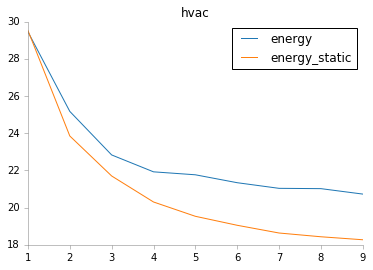

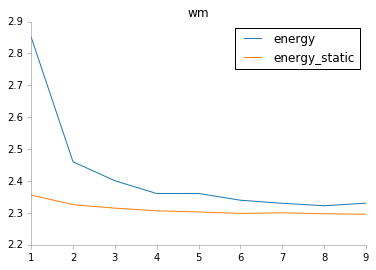

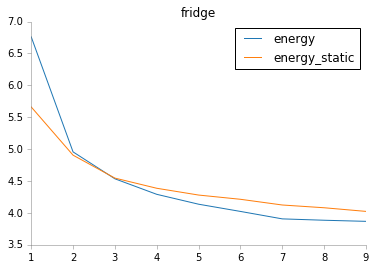

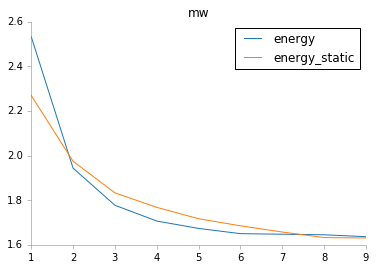

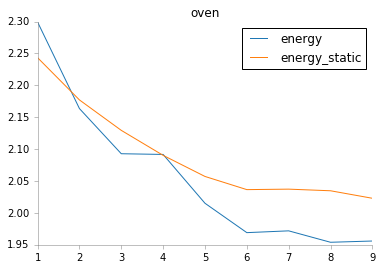

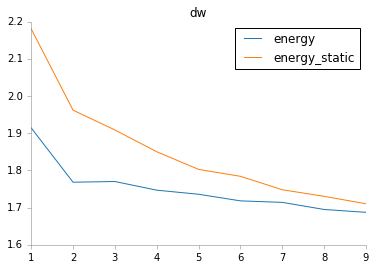

In [17]:
sensitivity = sensitivity_knn
sensitivity_all['KNN'] = sensitivity_knn
sanity_all['KNN'] = pd.Panel(sanity_num_points).mean()

for appliance in sensitivity:
    appliance_df = pd.DataFrame(sensitivity_knn[appliance])
    appliance_df.plot(title=appliance, color = tableau20blind[::2])
    format_axes(plt.gca())

### TF-1-at-a-time

In [18]:
sanity_num_points ={}
dataset = 'False'
cost = 'abs'
tf_custom= {}
sensitivity = {}
for appliance in tensor_custom_p.keys()[:]:
    print(appliance)
    sanity_num_points[appliance] = {}
    sensitivity[appliance] = {}
    tf_custom[appliance]= {}
    for case in [str(x) for x in range(1, 5)]:
        sanity_num_points[appliance][case]={}
        sensitivity[appliance][case] = {}
        best_error = 1e6
        for a in [str(x) for x in range(1, 10)]:
            alpha, beta, error, e = compute_rmse_fraction(appliance,tensor_custom_p[appliance][case][a][cost][dataset])
            assert(len(alpha)==len(beta))
            sanity_num_points[appliance][case][a]=len(alpha)
            sensitivity[appliance][case][a] = error
            if error < best_error:
                best_error = error
                tf_custom[appliance][case] = best_error

hvac
wm
fridge
mw
oven
dw


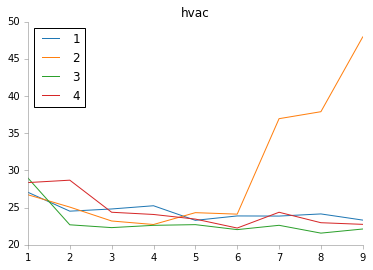

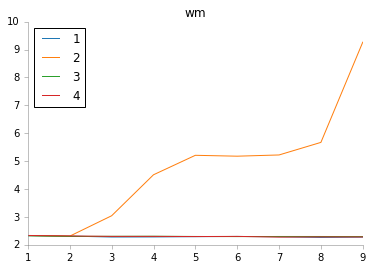

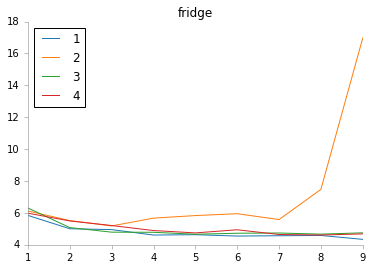

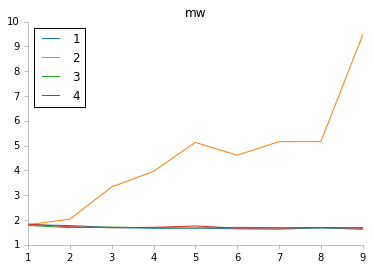

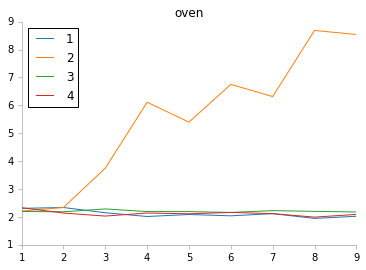

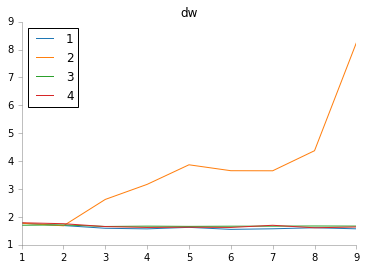

In [19]:
sensitivity_all['TF-1-at-time'] = sensitivity
sanity_all['TF-1-at-time'] = pd.Panel(sanity_num_points).mean()
for appliance in sensitivity:
    appliance_df = pd.DataFrame(sensitivity[appliance])
    appliance_df.plot(title=appliance, color=tableau20blind[::2])
    format_axes(plt.gca())

Something seems to be weird with case 2!

In [20]:
pd.Panel(sanity_num_points).mean()

,dw,fridge,hvac,mw,oven,wm
1,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0
2,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0
3,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0
4,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0


### TF-all-appliances

In [21]:
dataset = 'False'
tf_custom_all= {}
cost='abs'
sanity_num_points ={}
sensitivity ={}

for appliance in tensor_custom_p.keys()[:]:
    print(appliance)
    sensitivity[appliance] = {}
    tf_custom_all[appliance]= {}
    sanity_num_points[appliance]={}
    for case in [str(x) for x in range(1, 5)]:
        sensitivity[appliance][case] = {}
        
        sanity_num_points[appliance][case]={}
        best_error = 1e6
        for a in [str(x) for x in range(1, 11)]:
            try:
                pred = tensor_all_p[appliance][case][a][cost]
                
                if len(pred)<500:
                    continue
                if appliance=='hvac':
                    pred = pred[range(4, 10)]
                alpha, beta, error, e = compute_rmse_fraction(appliance,pred)
                assert(len(alpha)==len(beta))
                sanity_num_points[appliance][case][a]=len(alpha)
                sensitivity[appliance][case][a] = error
                if error < best_error:
                    best_error = error
                    tf_custom_all[appliance][case] = best_error
            except Exception, e:
                print(a, appliance, e)

hvac
wm
fridge
mw
oven
dw


In [22]:
pd.DataFrame(tf_custom_all)

,dw,fridge,hvac,mw,oven,wm
1,1.528092,5.634027,16.775930,1.823991,2.127827,2.300769
2,1.501393,5.122939,16.405830,1.786348,2.075386,2.291746
3,1.609879,5.337966,19.115027,1.785690,2.250096,2.310739
4,1.497215,5.082785,16.868967,1.751013,2.160746,2.293319


In [23]:
pd.Panel(sanity_num_points).mean()

,dw,fridge,hvac,mw,oven,wm
1,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0
2,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0
3,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0
4,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0


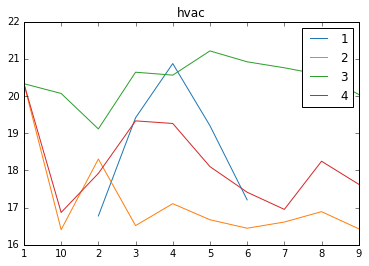

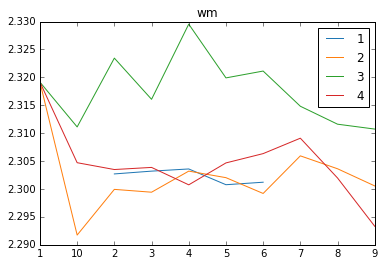

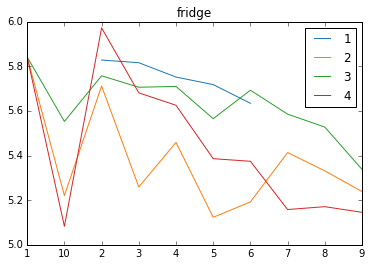

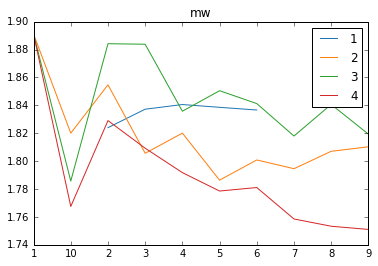

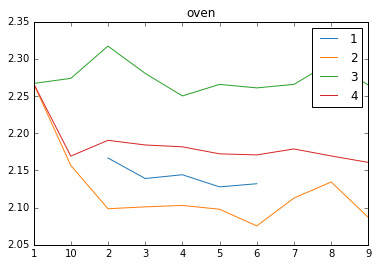

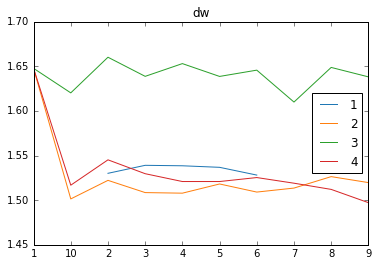

In [24]:
sensitivity_all['TF-all-appliances'] = sensitivity
sanity_all['TF-all-appliances'] = pd.Panel(sanity_num_points).mean()
for appliance in sensitivity:
    appliance_df = pd.DataFrame(sensitivity[appliance])
    appliance_df.plot(title=appliance, color=tableau20blind[::2])

### TF-1-at-time with static and weather

In [25]:
dataset = 'False'
tf_custom_static_weather= {}
cost= 'abs'
sanity_num_points = {}
sensitivity = {}
for appliance in tensor_custom_static_weather_p.keys()[:]:
    print(appliance)
    sensitivity[appliance] = {}
    sanity_num_points[appliance] = {}
    tf_custom_static_weather[appliance]= {}
    for static in ['None','static']:
        tf_custom_static_weather[appliance][static] = {}
        for weather in ['None','weather']:
            tf_custom_static_weather[appliance][static][weather] = {}
            sanity_num_points[appliance][(static, weather)] = {}

            best_error = 1e6
            sensitivity[appliance][(static, weather)] = {}
            for a in [str(x) for x in range(1, 10)]:
                alpha, beta, error, e = compute_rmse_fraction(appliance,tensor_custom_static_weather_p[appliance][dataset][a][static][weather][cost])
                assert(len(alpha)==len(beta))
                sanity_num_points[appliance][(static, weather)][a]=len(alpha)
                sensitivity[appliance][(static, weather)][a] = error
                if error < best_error:
                    best_error = error
                    tf_custom_static_weather[appliance][static][weather] = best_error

hvac
wm
fridge
mw
oven
dw


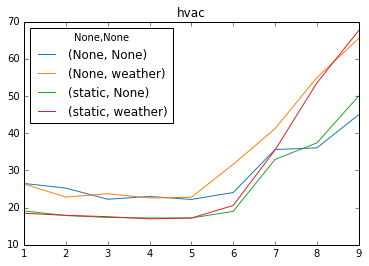

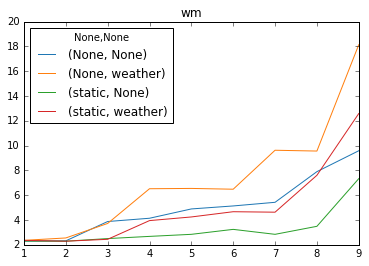

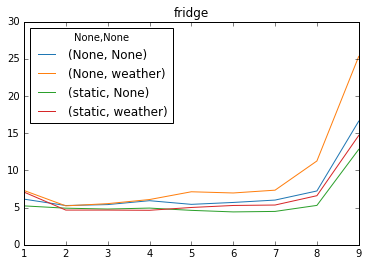

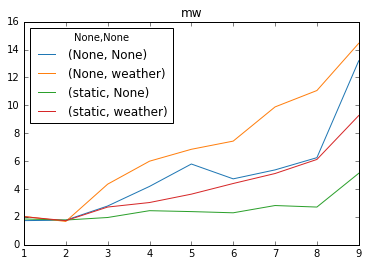

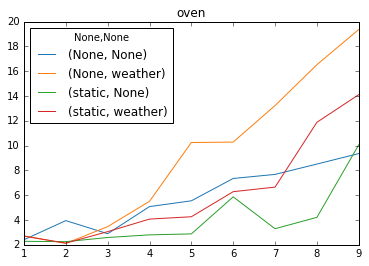

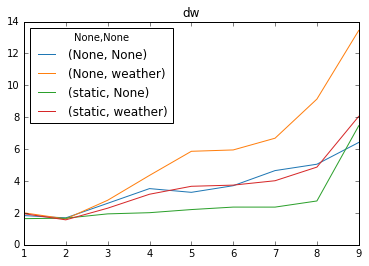

In [26]:
sensitivity_all['TF-1-at-time-static'] = sensitivity
sanity_all['TF-1-at-time-static'] = pd.Panel(sanity_num_points).mean()
for appliance in sensitivity:
    appliance_df = pd.DataFrame(sensitivity[appliance])
    appliance_df.plot(title=appliance,  color=tableau20blind[::2])

### TF-all-appliance with static and weather

In [27]:
dataset = 'False'
tf_custom_static_weather_all= {}
cost= 'abs'
sanity_num_points = {}
sensitivity = {}
for appliance in tensor_custom_static_weather_p.keys()[:]:
    print(appliance)
    sensitivity[appliance] = {}
    sanity_num_points[appliance] = {}
    tf_custom_static_weather_all[appliance]= {}
    for static in ['None','static']:
        tf_custom_static_weather_all[appliance][static] = {}
        for weather in ['None','weather']:
            tf_custom_static_weather_all[appliance][static][weather] = {}
            sanity_num_points[appliance][(static, weather)] = {}

            best_error = 1e6
            sensitivity[appliance][(static, weather)] = {}
            for a in [str(x) for x in range(1, 13)]:
                pred = tensor_all_static_p[appliance][static][weather][a]
                
                if len(pred) < 500:
                    continue
                if appliance == 'hvac':
                    pred = pred[range(4, 10)]
                alpha, beta, error, e = compute_rmse_fraction(appliance, pred)
                assert(len(alpha) == len(beta))
                sanity_num_points[appliance][(static, weather)][a] = len(alpha)
                sensitivity[appliance][(static, weather)][a] = error
                if error < best_error:
                    best_error = error
                    tf_custom_static_weather_all[appliance][static][weather] = best_error

hvac
wm
fridge
mw
oven
dw


In [28]:
pd.Panel(sanity_num_points).mean()

dw  fridge    hvac      mw    oven      wm
None   None     2184.0  2805.0  1510.0  1810.0  1049.0  1880.0
       weather  2184.0  2805.0  1510.0  1810.0  1049.0  1880.0
static None     2184.0  2805.0  1510.0  1810.0  1049.0  1880.0
       weather  2184.0  2805.0  1510.0  1810.0  1049.0  1880.0

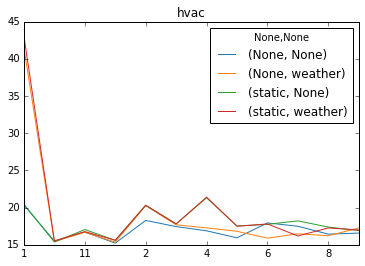

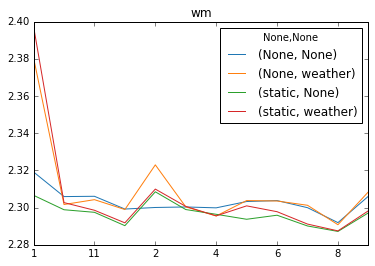

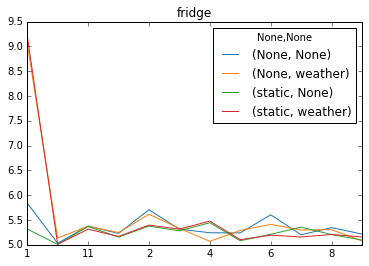

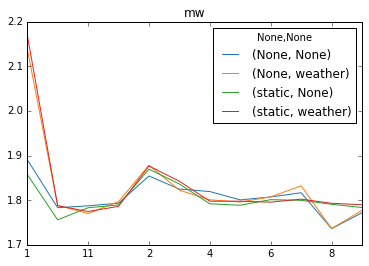

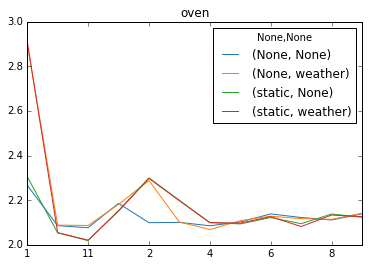

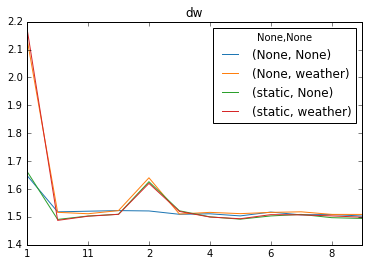

In [29]:
sensitivity_all['TF-all-appliances-static'] = sensitivity
sanity_all['TF-all-appliances-static'] = pd.Panel(sanity_num_points).mean()
for appliance in sensitivity:
    appliance_df = pd.DataFrame(sensitivity[appliance])
    appliance_df.plot(title=appliance , color=tableau20blind[::2])

### MF one at a time

In [30]:
mf_results = {}
dataset = 'False'
sanity_num_points = {}
sensitivity = {}
for appliance in mf_p:
    print(appliance)
    mf_results[appliance] = {}
    sanity_num_points[appliance] = {}
    sensitivity[appliance] = {}
    for feature in ['energy_static','energy']:
        mf_results[appliance][feature] = {}
        sensitivity[appliance][feature] = {}
        sanity_num_points[appliance][feature] = {}
        for cost in ['absolute']:
            mf_results[appliance][feature][cost] = {}

            least_error = 1000
            for lat in [str(x) for x in range(1, 10)]:
                try:
                    pred = mf_p[appliance][feature][cost][dataset][lat]
                    if appliance=="hvac":
                        pred = pred[['hvac_%d' %month for month in range(5, 11)]]
                    alpha, beta, error, e  = compute_rmse_fraction(appliance, pred)
                    sensitivity[appliance][feature][lat] = error
                    sanity_num_points[appliance][feature][lat] = len(alpha)
                    if error < least_error:
                        least_error = error
                        best_k = lat
                except Exception, e:
                    pass
            mf_results[appliance][feature][cost] = least_error

hvac
wm
fridge
mw
oven
dw


In [31]:
mf_results

{'dw': {'energy': {'absolute': 1.5012772899373215},
  'energy_static': {'absolute': 1.4715351665081096}},
 'fridge': {'energy': {'absolute': 5.2293462596939548},
  'energy_static': {'absolute': 4.8029828646102146}},
 'hvac': {'energy': {'absolute': 12.854837898285551},
  'energy_static': {'absolute': 13.999789283357215}},
 'mw': {'energy': {'absolute': 1.7472505848035889},
  'energy_static': {'absolute': 1.7385316886088629}},
 'oven': {'energy': {'absolute': 2.0894226487038976},
  'energy_static': {'absolute': 2.111073384577506}},
 'wm': {'energy': {'absolute': 2.298673717073219},
  'energy_static': {'absolute': 2.2834520508455545}}}

In [32]:
pd.Panel(sanity_num_points).mean()

,dw,fridge,hvac,mw,oven,wm
energy,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0
energy_static,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0


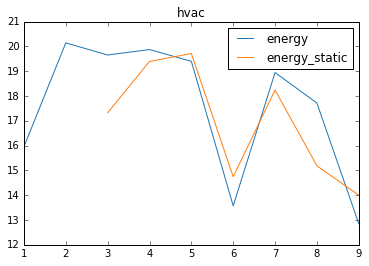

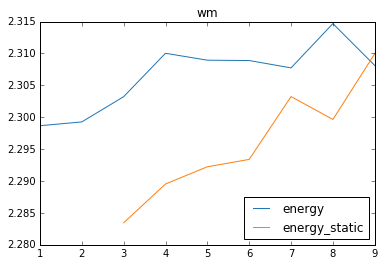

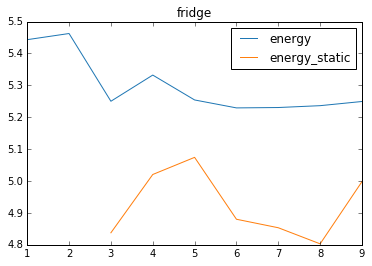

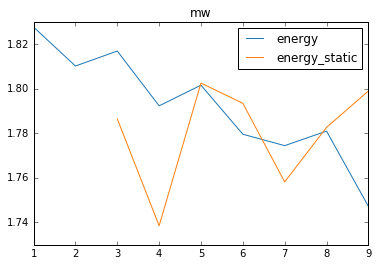

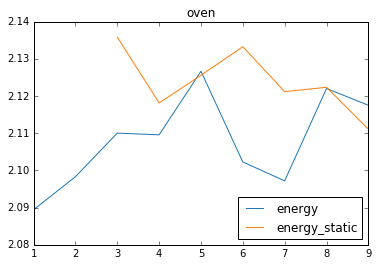

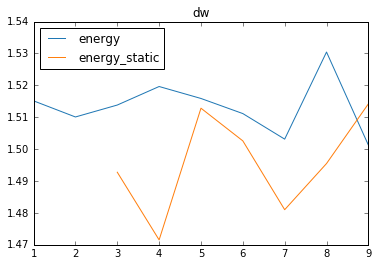

In [33]:
sensitivity_all['MF-1-at-time'] = sensitivity
sanity_all['Mf-1-at-time'] = pd.Panel(sanity_num_points).mean()
for appliance in sensitivity:
    appliance_df = pd.DataFrame(sensitivity[appliance])
    appliance_df.plot(title=appliance , color=tableau20blind[::2])

### MF all

In [34]:
mf_all_results = {}
sensitivity = {}
sanity_num_points = {}

dataset = 'False'
cost = 'absolute'
for appliance in mf_p:
    print(appliance)
    mf_all_results[appliance] = {}
    sensitivity[appliance] = {}
    sanity_num_points[appliance] = {}
    
    for feature in ['energy_static','energy']:
        mf_all_results[appliance][feature] = {}
        sensitivity[appliance][feature] = {}
        sanity_num_points[appliance][feature] = {}
        
        
        least_error = 1000
        for lat in [str(x) for x in range(1, 10)]:
            try:
                pred = mf_all_p[appliance][feature][cost][dataset][lat]
                if appliance=="hvac":
                    pred = pred[['hvac_%d' %month for month in range(5, 11)]]
                alpha, beta, error, e  = compute_rmse_fraction(appliance, pred)
                sensitivity[appliance][feature][lat] = error
                sanity_num_points[appliance][feature][lat] = len(alpha)
                
                if error < least_error:
                    least_error = error
                    best_k = lat
            except:
                pass
        mf_all_results[appliance][feature] = least_error

hvac
wm
fridge
mw
oven
dw


In [35]:
pd.DataFrame(mf_all_results)

,dw,fridge,hvac,mw,oven,wm
energy,1.491675,5.29530,19.118563,1.791761,2.206203,9.913187
energy_static,1.471653,4.67519,18.250842,1.752604,2.208645,10.053972


In [36]:
pd.Panel(sanity_num_points).mean()

,dw,fridge,hvac,mw,oven,wm
energy,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0
energy_static,2184.0,2805.0,1510.0,1810.0,1049.0,1880.0


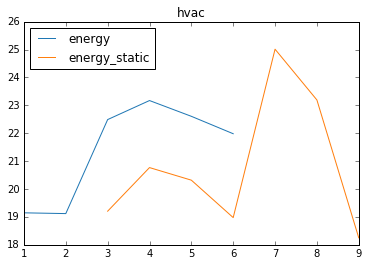

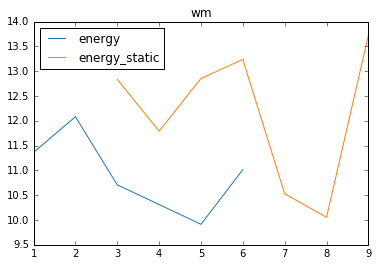

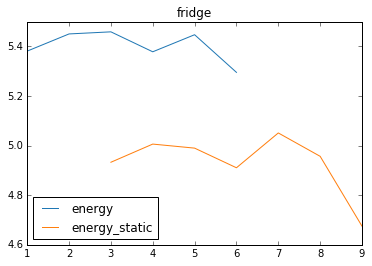

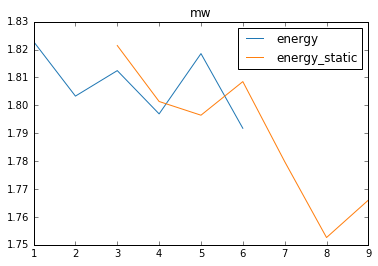

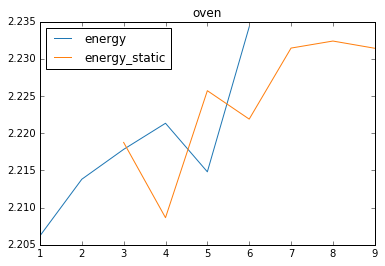

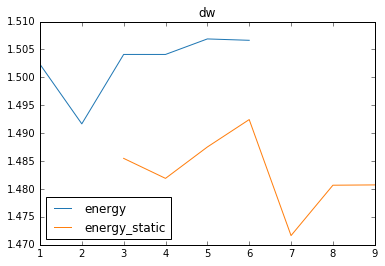

In [37]:
sensitivity_all['MF-all-appliances'] = sensitivity
sanity_all['MF-all-appliances'] = pd.Panel(sanity_num_points).mean()
for appliance in sensitivity:
    appliance_df = pd.DataFrame(sensitivity[appliance])
    appliance_df.plot(title=appliance , color=tableau20blind[::2])

In [38]:
out = {}
for static in ['None','static']:
    for weather in ['None','weather']:
        out[(static, weather)] =  {}
        for lat in range(1, 13):
            out[(static, weather)][lat] =  compute_rmse_fraction('hvac',tensor_all_static_p['hvac'][static][weather][str(lat)][range(4, 10)])[2]

In [39]:
pd.DataFrame(out)

None                static           
         None    weather       None    weather
1   20.330027  41.449429  20.453350  43.015607
2   18.274443  20.272239  20.305375  20.321839
3   17.448296  17.690388  17.811186  17.799734
4   16.879236  17.275695  21.313343  21.409387
5   15.941061  16.815723  17.529288  17.490351
6   17.938264  15.894465  17.742492  17.801730
7   17.495227  16.476775  18.217620  16.188829
8   16.435770  16.220615  17.384418  17.264768
9   16.575224  17.249739  16.913791  16.991526
10  15.510604  15.428778  15.370857  15.522182
11  16.716594  16.684636  17.050902  16.773935
12  15.225988  15.357158  15.594925  15.616739

In [40]:
case_2 = {}

for static in ['None','static']:
    for weather in ['None','weather']:
        case_2[(static, weather)] =  {}
        for appliance in mf_p.keys():
            max_error = 1e6
            for lat in range(1, 13):
                if appliance=='hvac':
                    pred = tensor_all_static_p[appliance][static][weather][str(lat)][range(4, 10)]
                else:
                    pred = tensor_all_static_p[appliance][static][weather][str(lat)]
                error = compute_rmse_fraction(appliance,pred)[2]
                if error<max_error:
                    max_error=error
                    case_2[(static, weather)][appliance]=max_error

In [41]:
mf_relative = {}
mf_abs = {}
for appliance in mf_results.keys():
    for cost in ['absolute']:
        if cost=="absolute":
            mf_abs[appliance] =  pd.DataFrame(mf_results[appliance]).ix[cost]
        else:
            mf_relative[appliance] =  pd.DataFrame(mf_results[appliance]).ix[cost]


In [42]:
pd.DataFrame(mf_abs)

,dw,fridge,hvac,mw,oven,wm
energy,1.501277,5.229346,12.854838,1.747251,2.089423,2.298674
energy_static,1.471535,4.802983,13.999789,1.738532,2.111073,2.283452


In [43]:
results_df ={}
results_df[('MF-1-at-a-time','Energy')] = pd.DataFrame(mf_abs).ix['energy']
results_df[('MF-1-at-a-time','Energy+Static')] = pd.DataFrame(mf_abs).ix['energy_static']

results_df[('MF-all-appliances','Energy')] = pd.DataFrame(mf_all_results).ix['energy']
results_df[('MF-all-appliances','Energy+Static')] = pd.DataFrame(mf_all_results).ix['energy_static']

#results_df[('MF (Rel)','Energy')] = pd.DataFrame(mf_relative).ix['energy']
#results_df[('MF (Rel)','Energy+Static')] = pd.DataFrame(mf_relative).ix['energy_static']

#results_df[('Tensor (Parafac)','Energy')] = pd.Series(tensor_parafac_results)


results_df[('KNN','Energy')] = pd.DataFrame(knn).ix['energy']
results_df[('KNN','Energy+Static')] = pd.DataFrame(knn).ix['energy_static']
#results_df[('KNN','Oracle')] = pd.Series(knn_oracle)

#results_df[('KNN (ML)','Energy')] = pd.DataFrame(ml_results).ix['energy']
#results_df[('KNN (ML)','Energy+Static')] = pd.DataFrame(ml_results).ix['energy_static']

for case in [1, 2, 3, 4]:
    results_df[('TF-1-at-a-time-'+str(case),'Energy')] = pd.DataFrame(tf_custom).ix[str(case)]
    results_df[('TF-all-appliances-'+str(case),'Energy')] = pd.DataFrame(tf_custom_all).ix[str(case)]
    
del results_df[('TF-all-appliances-'+str(2),'Energy')]

results_df[('TF-all-appliances-'+str(2),'Energy')] = pd.DataFrame(case_2)[('None','None')]
results_df[('TF-all-appliances-'+str(2),'Energy+Static')] = pd.DataFrame(case_2)[('static','None')]
results_df[('TF-all-appliances-'+str(2),'Energy+Weather')] = pd.DataFrame(case_2)[('None','weather')]
results_df[('TF-all-appliances-'+str(2),'Energy+Static+Weather')] = pd.DataFrame(case_2)[('static','weather')]

In [44]:
pd.DataFrame(results_df)

KNN               MF-1-at-a-time                \
           Energy Energy+Static         Energy Energy+Static   
dw       1.687300      1.710349       1.501277      1.471535   
fridge   3.867789      4.023775       5.229346      4.802983   
hvac    20.727005     18.271386      12.854838     13.999789   
mw       1.636434      1.630457       1.747251      1.738532   
oven     1.953965      2.022953       2.089423      2.111073   
wm       2.322542      2.295827       2.298674      2.283452   

       MF-all-appliances               TF-1-at-a-time-1 TF-1-at-a-time-2  \
                  Energy Energy+Static           Energy           Energy   
dw              1.491675      1.471653         1.553212         1.681253   
fridge          5.295300      4.675190         4.341469         5.183059   
hvac           19.118563     18.250842        23.289010        22.728073   
mw              1.791761      1.752604         1.625588         1.813610   
oven            2.206203      2.208645         1.945971         2.209940   
wm              9.913187     10.053972         2.263662         2.311223   

       TF-1-at-a-time-3 TF-1-at-a-time-4 TF-all-appliances-1  \
                 Energy           Energy              Energy   
dw             1.656754         1.609805            1.528092   
fridge         4.661915         4.613787            5.634027   
hvac          21.569789        22.251935           16.775930   
mw             1.674987         1.668383            1.823991   
oven           2.159225         1.992201            2.127827   
wm             2.294200         2.276813            2.300769   

       TF-all-appliances-2                                                     \
                    Energy Energy+Static Energy+Static+Weather Energy+Weather   
dw                1.503086      1.490928              1.487540       1.508857   
fridge            5.032337      5.007116              5.011045       5.070320   
hvac             15.225988     15.370857             15.522182      15.357158   
mw                1.736230      1.755955              1.774656       1.736521   
oven              2.076462      2.018895              2.020849       2.068469   
wm                2.291921      2.287192              2.287487       2.290799   

       TF-all-appliances-3 TF-all-appliances-4  
                    Energy              Energy  
dw                1.609879            1.497215  
fridge            5.337966            5.082785  
hvac             19.115027           16.868967  
mw                1.785690            1.751013  
oven              2.250096            2.160746  
wm                2.310739            2.293319

In [45]:
def highlight_min(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_min = s == s.min()
    return ['background-color: gray' if v else '' for v in is_min]

In [50]:
pd.set_option('precision', 4)
out = pd.DataFrame(results_df).T
out.columns = [str.capitalize(x) for x in out.columns]
import seaborn as sns

cm = sns.light_palette("orange", as_cmap=True)

s = out.style.background_gradient(cmap=cm)
s
#out.style.apply(highlight_min)
#out.style.set_properties(**{'text-align': 'right'})
